In [58]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [115]:
# extract best params, scores, links, and PR scores for a complete benchmark
import os
import ast
import importlib
import pandas as pd
import numpy as np
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from geneRNI import search_param
from geneRNI import tools
from geneRNI import geneRNI as ni
import itertools
import random
importlib.reload(search_param)
importlib.reload(ni)
importlib.reload(tools)
dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'
output_dir=os.path.join(dir_main,'results')

estimator_t = 'RF' #'HGB'
out_defaults = tools.Settings.default(estimator_t=estimator_t)

scores_stack = {}
params_stack = {}
PR_stack = {}
def dream4_complete(estimator_t):
    sizes = [10]
    networks = [1,2,3,4,5]
    for size in sizes:
        scores_stack.update({size:{}})
        params_stack.update({size:{}})
        PR_stack.update({size:{}})
        for network in networks:
            out_data = tools.Benchmark.process_data_dream4(size=size, network=network, estimator_t=estimator_t, verbose=False)
            results_dir = f'results/dream4/{estimator_t}/param_search_dream_{size}_{network}.txt'
            with open(results_dir,'r') as f:
                out = ast.literal_eval(f.read())
            best_scores, best_params = out['best_scores'], out['best_params']
            params_stack[size].update({network:best_params})
            # nework inference
            _, _, _, gene_names = tools.Benchmark.f_data_dream(size, network)
            _, train_scores, links, oob_scores, test_scores = ni.network_inference(Xs=out_data.Xs_train, ys=out_data.ys_train, 
                                                                                   gene_names=gene_names,
                                                                                   param=out_defaults.param, Xs_test=out_data.Xs_test, 
                                                                                   ys_test=out_data.ys_test, param_unique=best_params, verbose=False)
            if estimator_t == 'RF':
                scores_stack[size].update({network:oob_scores})
            else:
                scores_stack[size].update({network:test_scores})
            
            # calculate PR
            golden_links = tools.Benchmark.f_golden_dream(size, network)
            precision, recall, average_precision, average_precision_overall = tools.GOF.calculate_PR(gene_names, links, golden_links, details=True)
#             tools.GOF.PR_curve_gene(gene_names, recall, precision, average_precision)
            PR_stack[size].update({network:average_precision_overall})            

dream4_complete(estimator_t)     

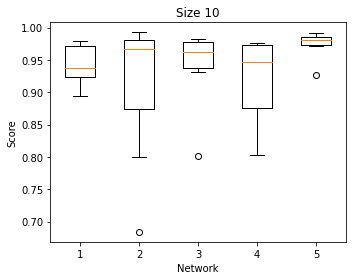

In [116]:
# plot score results
from geneRNI import tools
importlib.reload(tools)
# plot scores for individual network
tools.GOF.boxplot_scores_groupOfgroup([list(item.values()) for item in scores_stack.values()] ,
                                      tags = [str(i) for i in range(1,6)], titles=['Size 10', 'Size 100'])


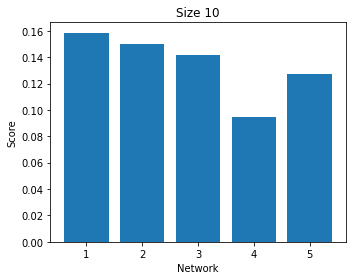

In [118]:
# plot PR results
from geneRNI import tools
importlib.reload(tools)

tools.GOF.barplot_PR_groupOfgroup([list(item.values()) for item in PR_stack.values()] ,
                                      tags = [str(i) for i in range(1,6)], titles=['Size 10', 'Size 100'])


{10: {1: [{'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 3}, {'min_samples_leaf': 1}, {'min_samples_leaf': 2}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}], 2: [{'min_samples_leaf': 2}, {'min_samples_leaf': 1}, {'min_samples_leaf': 3}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 3}, {'min_samples_leaf': 3}, {'min_samples_leaf': 1}, {'min_samples_leaf': 3}], 3: [{'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 2}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 3}, {'min_samples_leaf': 2}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}], 4: [{'min_samples_leaf': 3}, {'min_samples_leaf': 1}, {'min_samples_leaf': 2}, {'min_samples_leaf': 2}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 1}, {'min_samples_leaf': 2}, {'min_samples_leaf': 1}, 

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (5, 10).

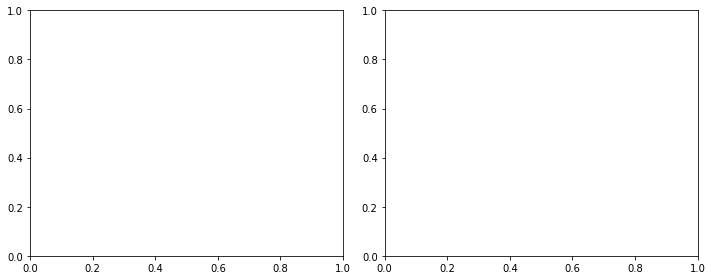

In [109]:
# plot best params 
from geneRNI import tools
importlib.reload(tools)
print(params_stack)
tools.GOF.barplot_PR_groupOfgroup([list(item.values()) for item in params_stack.values()] ,
                                      tags = [str(i) for i in range(1,6)], titles=['Size 10', 'Size 100'])

In [ ]:
# post processing: calculate links, golden precision scores, and plot param distribution 
import os
import ast
import importlib
import pandas as pd
import numpy as np
from geneRNI import search_param
from geneRNI import tools
from geneRNI import geneRNI as ni
import itertools
import random
importlib.reload(search_param)
importlib.reload(ni)
importlib.reload(tools)

dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'
output_dir=os.path.join(dir_main,'results')
# choose the study 
# size, network, study= 10, 1, 'dreams'
method, noise_level, network, study= 'GeneNetWeaver', 'LowNoise', 'Network1', 'GRNbenchmark'

# recreate the experiment
estimator_t = 'RF' #'HGB'
study = 'GRNbenchmark' #'GRNbenchmark'

if study == 'dreams': # dream as target study
    size, network = 10, 1 # [10,100] [1-5]
    out_data = tools.Benchmark.process_data_dreams(size=size, network=network, estimator_t=estimator_t)
    results_dir = f'results/param_search_dream_{size}_{network}.txt'
elif study == 'GRNbenchmark':
    method, noise_level, network = 'GeneNetWeaver', 'LowNoise', 'Network1'
    out_data = tools.Benchmark.process_data_GRNbenchmark(method, noise_level, network, estimator_t=estimator_t)
    results_dir = f'results/param_search_GRNbenchmark_{method}_{noise_level}_{network}.txt'
else:
    raise ValueError('Define')
out_defaults = tools.Settings.default(estimator_t=estimator_t)

# retreieve param search results
with open(results_dir,'r') as f:
    out = ast.literal_eval(f.read())
best_scores, best_params = out['best_scores'], out['best_params']

# param_unique = tools.param_unique_average(best_params)
param_unique = best_params
# nework inference
_, train_scores, links, oob_scores, test_scores = ni.network_inference(Xs=out_data.Xs_train, ys=out_data.ys_train, 
                                                                       param=out_defaults.param, Xs_test=out_data.Xs_test, 
                                                                       ys_test=out_data.ys_test, param_unique=param_unique)
# plot
with open(os.path.join(output_dir,'permts.txt'),'r') as f:
    permts = ast.literal_eval(f.read())
with open(os.path.join(output_dir, 'sampled_permts.txt'), 'r') as f:
    sampled_permts = ast.literal_eval(f.read())
search_param.plot(best_params,best_scores, priors = permts, samples = sampled_permts)

In [ ]:
# plot precision vs racals
precision, recall, average_precision = utils.calculate_PR(gene_names=gene_names, scores=scores, tests=tests, details = True)

utils.PR_curve_average(recall=recall, precision=precision, average_precision=average_precision)
utils.PR_curve_gene(gene_names=gene_names[0:2], precision=precision, recall=recall, average_precision=average_precision)

In [ ]:
# write test data for R
TS_data, time_points, SS_data, gene_names = f_data_dream(size, network)
np.savetxt('data/test_data.csv',SS_data.transpose(), delimiter=',')

In [ ]:
# calculate precision score for r results
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'

sys.path.insert(0, dir_main)
from geneRNI import tools

size = 10 # [10,100]
network = 1 # [1-5]

def f_golden_dream(size, network): 
    """ retreives golden links for dreams for given size and network """
    dir_ = os.path.join(dir_main,f'dynGENIE3/dynGENIE3_data/dream4/gold_standards/{size}/DREAM4_GoldStandard_InSilico_Size{size}_{network}.tsv')
    return pd.read_csv(dir_, names=['Regulator','Target','Weight'] ,sep='\t') 
def f_dir_links(size, network):
    """ returns the dir to the stored links """
    return os.path.join(dir_main,f'results/test_links.csv')
def f_data_dream(size, network): 
    """ retreives train data for dreams for given size and network"""
    (TS_data, time_points, SS_data) = pd.read_pickle(os.path.join(dir_main,f'dynGENIE3/dynGENIE3_data/dream4/data/size{size}_{network}_data.pkl'))
    gene_names = [f'G{i}' for i in range(1,size+1)]
    return TS_data, time_points, SS_data, gene_names
TS_data, time_points, SS_data, gene_names = f_data_dream(size, network)
links = pd.read_csv(f_dir_links(size, network) )
goldens = f_golden_dream(size, network)
# sort links based on each gene
links_sorted = tools.sort_links(links,gene_names)
goldens_sorted = tools.sort_links(goldens,gene_names)
# calculate PR
scores = np.array(list(goldens_sorted.values()))
tests = np.array(list(links_sorted.values()))
_, _, _, average_precision_overall = tools.calculate_PR(gene_names=gene_names, scores=scores, tests=tests, details = False)
print('average precision : ',average_precision_overall)

In [154]:
## dynGENIE3
import importlib
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'

sys.path.insert(0, os.path.join(dir_main,'..'))
from dynGENIE3 import dynGENIE3 
importlib.reload(dynGENIE3)
import _pickle
links_file_name = os.path.join(dir_main,'results/links_dynGENIE3.txt')
TS_data, time_points, SS_data, gene_names = tools.Benchmark.f_data_dream(size=10,network=1)
VIM, alphas, prediction_score, stability_score, treeEstimators,scores_train = dynGENIE3.dynGENIE3(TS_data = TS_data, SS_data = SS_data,time_points=time_points, compute_quality_scores=True)
dynGENIE3.get_link_list(VIM, gene_names=gene_names, file_name=links_file_name)

Tree method: RF
K: sqrt
Number of trees: 1000
alpha min: 0.003434072665420958
alpha max: 0.025135982338199504


running single threaded jobs
Gene 1/10...
Gene 2/10...
Gene 3/10...
Gene 4/10...
Gene 5/10...
Gene 6/10...
Gene 7/10...
Gene 8/10...
Gene 9/10...
Gene 10/10...
Elapsed time: 11.84 seconds


In [163]:
# post process dynGENIE3
import pandas as pd
# oob score
print(f'oob score: mean {np.mean(prediction_score)} std {np.std(prediction_score)}')
links_df = pd.read_csv(links_file_name, delim_whitespace=True, header=None)
links_df.columns = ['Regulator','Target','Weight']
links_df = tools.Links.sort(links_df, gene_names)
golden_links = tools.Benchmark.f_golden_dream(10,1)
_,_,_, average_PR = tools.GOF.calculate_PR(links=links_df, golden_links=golden_links, gene_names=gene_names)
print(-np.log10(.27))

oob score: mean 0.7653465206279951 std 0.20966361225633456
0.5686362358410126
